In [20]:
import textgrid as t
import wave
from matplotlib import pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (8.0, 16.0)
import numpy as np

In [21]:
# open the sound file
w = wave.open('CATH1.WAV')

# sample freq 
params = w.getparams()
freq = params[2]

# open the annotation
f = open('CATH1.TextGrid','r')
fid = t.TextGrid(f.read())

In [22]:
all_sylls = []
for i, tier in enumerate(fid):
    # get list of annotations in this file
    trans = tier.make_simple_transcript()
    
    # search for something in the list
    matches = [x for x in trans if x[2] == "naa"]

    # for every matched annotation
    for item in matches:
        start_pos = int(float(item[0]) * freq)
        stop_pos = int(float(item[1]) * freq)
        w.setpos(start_pos)
    
        # get syllable data
        sample = w.readframes(stop_pos-start_pos)
        waveform = np.fromstring(sample, 'Int16')
    
        # store syllable data 
        all_sylls.append(waveform.tolist())    

In [23]:
# take a sample

x = []
y = []

data = np.asarray(all_sylls[0])
print np.shape(data)

len_syllable  = len(data)

# repeat this signal a couple of times
data = np.tile(data,3)
print np.shape(data)

# normalize to [0 1] 
data = (data - min(data)) / float((max(data)-min(data)))


(4154,)
(12462,)


In [24]:
# now proceed with reservoir action:

# network size
N = 100

# network connectivity
netConn = 10./N

# requires sprandn function which is not implemented in scipy
import numpy.random
import scipy.sparse

def sprandn(m, n, density):
    nnz = max(0, min(int(m*n*density), m*n))
    seq = np.random.permutation(m*n)[:nnz]
    data = np.random.randn(nnz)
    return scipy.sparse.csr_matrix((data, (seq/n,seq%n)), shape=(m,n)).todense()

# initialize random weights
W_unscaled = sprandn(N,N,netConn)


In [25]:
import scipy.linalg
# compute the spectral radius (= largest eigenvalue)
def getSpecRad(m):
    specRad, largestEigenvec = np.abs(scipy.linalg.eigh(m,eigvals=(N-1, N-1)))
    return specRad[0]

specRad = getSpecRad(W_unscaled)
print "Spectral radius of the random matrix: {}".format(specRad)

W_raw = W_unscaled/specRad * 1

# the new spectral radius
print "Now the spectral radius is {}".format(getSpecRad(W_raw))

Spectral radius of the random matrix: 7.39820582032
Now the spectral radius is 1.0


In [26]:
netInputScaling = 1.2
numInputDims = 1

# Input weights
W_in = netInputScaling * np.random.normal(0,1,(N,numInputDims))

# Bias weights 
biasScaling = 0.4
W_bias = biasScaling * np.random.normal(0,1,(N,1))

In [27]:
washoutTimesteps = 0
learnTimesteps = len(data)

# force different timescales by different leaky integrator rates
a = np.asarray([np.linspace(0.0001,1, N)]).T

# init empty state
x = np.zeros((N, 1))

stateCollector = np.zeros((N, learnTimesteps))
inputCollector = np.zeros((numInputDims, learnTimesteps))

washoutStateCollector = np.zeros((N, washoutTimesteps))

for t in xrange(washoutTimesteps + learnTimesteps):
    # get input from pattern-function
    u = data[t]
    
    xold = x;
    # update rule
    x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)
    x = np.multiply((1-a),xold) + np.multiply(a, x)
    
    # if we are over the washout period, we start saving states
    if t >= washoutTimesteps:
        # we need to transpose x and u,
        # because accessing a row OR column in a numpy matrix always resturns a row vector
        stateCollector[:, t - washoutTimesteps] = x.T
        inputCollector[:, t - washoutTimesteps] = u.T
    
        if(t == 300):
            startXs = x
    
    # save washout state sequence as well for inspection
    else:
        washoutStateCollector[:, t] = x.T


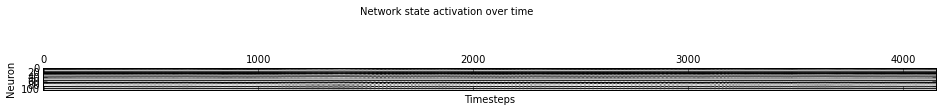

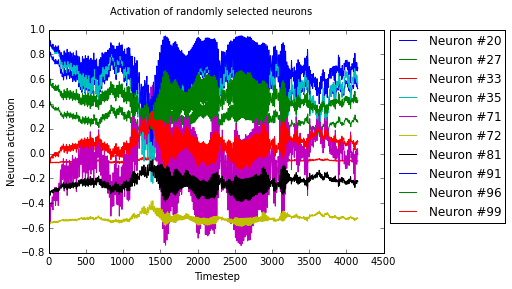

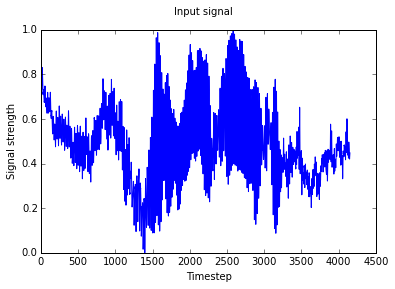

In [28]:
# show the states over time
plt.matshow(stateCollector[:,-len_syllable:], cmap=plt.cm.gray);
plt.suptitle("Network state activation over time");
plt.xlabel("Timesteps");
plt.ylabel("Neuron");

# plot 5 randomly selected neurons
plt.figure();
neuron_idxs = np.random.permutation(range(N))[0:10]
neuron_idxs.sort()
for i, neuron in enumerate(neuron_idxs):
    plt.plot(stateCollector[neuron ,-len_syllable:], label="Neuron #{}".format(neuron));
plt.suptitle("Activation of randomly selected neurons");
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.xlabel("Timestep");
plt.ylabel("Neuron activation");

    
# plot input
plt.figure();
plt.plot(inputCollector[0,0:len_syllable]);
plt.suptitle("Input signal");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

(array([  1.,   2.,   1.,  10.,  27.,  40.,  10.,   6.,   2.,   1.]),
 array([-0.46192919, -0.37389177, -0.28585435, -0.19781693, -0.10977952,
        -0.0217421 ,  0.06629532,  0.15433274,  0.24237016,  0.33040758,
         0.418445  ]),
 <a list of 10 Patch objects>)

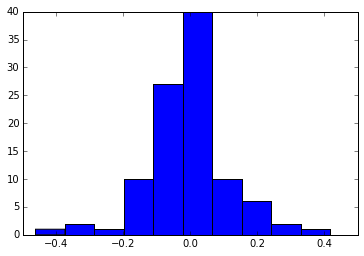

In [29]:
def ridgeRegression(A, b, alpha):
    aI = alpha * np.eye(A.shape[1])
    first = np.linalg.inv(np.dot(A.T, A) + np.dot(aI.T, aI))
    return np.dot(first , np.dot(A.T, b))

# we need to transpose out data to fit into the equation
W_out = ridgeRegression(
    A = stateCollector.T,
    b = inputCollector.T,
    alpha = 0.01)

plt.hist(W_out, 10)

In [30]:
testTimesteps = len_syllable

# continue with last state
x = x

testOutputCollector = np.zeros((numInputDims, testTimesteps))
testInputCollector = np.zeros((numInputDims, testTimesteps))

for t in xrange(testTimesteps):
    # get input from pattern-function after washout and learning phase
    # this means we just continue after this phase
    u = data[t]
    
    # update rule
    x = np.tanh(np.dot(W_raw, x) + np.dot(W_in, u) + W_bias)
    
    # start computing outputs
    output = np.dot(x.T, W_out)
    testOutputCollector[:, t] = output.T
    testInputCollector[:, t] = u.T

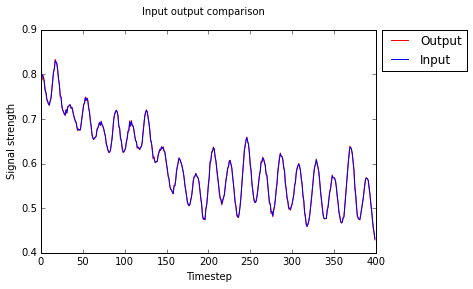

In [31]:
#plt.plot(testOutputCollector[0,0:len_syllable], 'r', label="Output");
#plt.plot(testInputCollector[0,0:len_syllable], 'b', label="Input");
plt.plot(testOutputCollector[0,0:400], 'r', label="Output");
plt.plot(testInputCollector[0,0:400], 'b', label="Input");
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.suptitle("Input output comparison");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");

In [32]:
def NRMSE(output, target):
    error = target - output
    
    # ptp = range
    peakToPeak = np.ptp(target, axis=1)
    rmse = np.sqrt(np.mean(error**2, axis=1))
    nrmse = rmse / peakToPeak
    return nrmse

print 'NRMSE Readout: {}'.format(NRMSE(testOutputCollector, testInputCollector))

NRMSE Readout: [ 0.00766477]


Spec Rad of the loaded weight matrix 12.0715255347
mean NRMSE W: 0.00702117029557


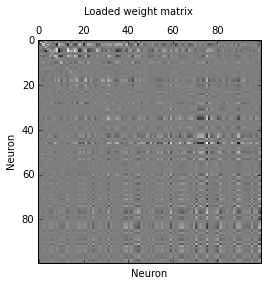

In [57]:
stateCollectorOld = np.zeros((N, learnTimesteps))
stateCollectorOld[:,1:] = stateCollector[:,0:-1]

target = np.arctanh(stateCollector) - np.tile(W_bias, (1, learnTimesteps))

W_loaded = ridgeRegression(stateCollectorOld.T, target.T, 0.1).T

# Herberts regression
#xxT = np.dot(stateCollectorOld, stateCollectorOld.T) 
#W_loaded = np.dot(np.dot(np.linalg.inv(xxT +  0.01 * np.eye(N)), stateCollectorOld), target.T).T

loadSpecRad = getSpecRad(W_loaded)
print 'Spec Rad of the loaded weight matrix ' + str(loadSpecRad)

# training error per neuron
nrmse_loading = NRMSE(np.dot(W_loaded, stateCollectorOld), target)
print 'mean NRMSE W: ' + str(np.mean(nrmse_loading))


plt.matshow(W_loaded, cmap=plt.cm.gray);
plt.suptitle("Loaded weight matrix");
plt.xlabel("Neuron");
plt.ylabel("Neuron");

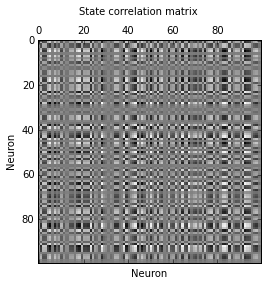

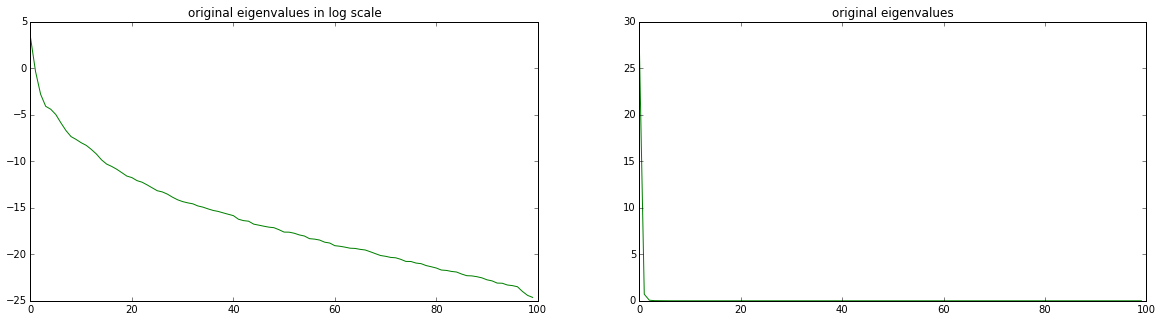

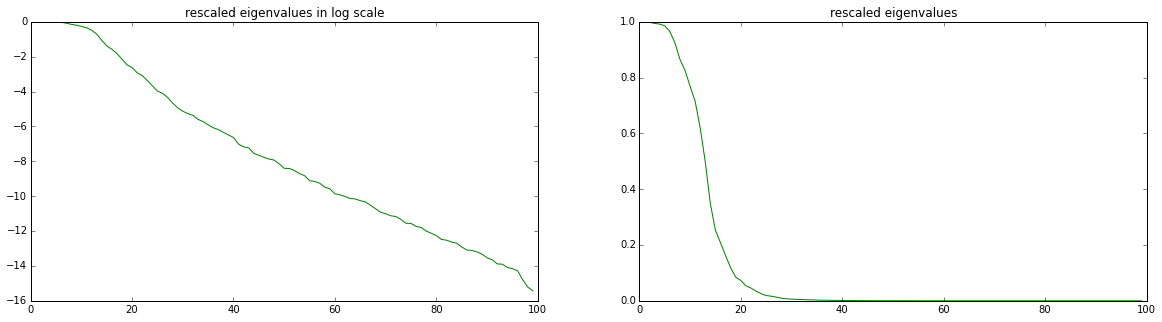

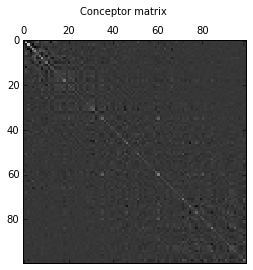

In [58]:
I = np.eye(N)

# Aperture alpha
alpha = 100

# State correlation matrix
R = np.dot(stateCollector, stateCollector.T) / learnTimesteps
plt.matshow(R, cmap=plt.cm.gray);
plt.suptitle("State correlation matrix");
plt.xlabel("Neuron");
plt.ylabel("Neuron");

# What other matrices could we use? Covariance matrix? Cross-correlation matrix?

U,S,V = np.linalg.svd(R, full_matrices=True) 
plt.figure(figsize=(20,5))
plt.subplot(1,2,1).set_title("original eigenvalues in log scale")
plt.plot(np.log(S), 'g')
plt.subplot(1,2,2).set_title("original eigenvalues")
plt.plot(S, 'g')

S = np.diag(S)    

Snew = (np.dot(S,np.linalg.inv(S + (alpha**-2)*I)))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1).set_title("rescaled eigenvalues in log scale")
plt.plot(np.log(np.diagonal(Snew)), 'g')
plt.subplot(1,2,2).set_title("rescaled eigenvalues")
plt.plot(np.diagonal(Snew), 'g')

# svd backwards with new S
C = np.dot(U,np.dot(Snew,V))

plt.matshow(C, cmap=plt.cm.gray);
plt.suptitle("Conceptor matrix");

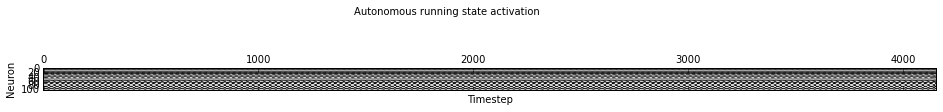

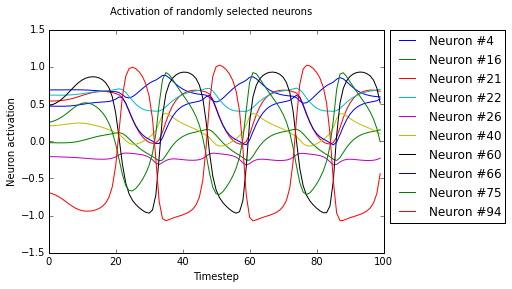

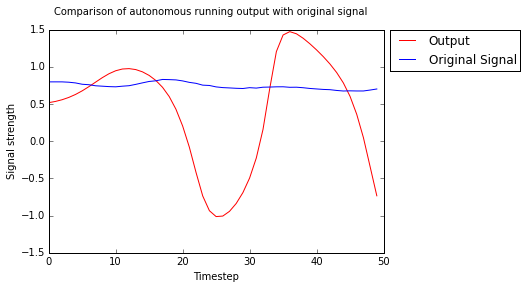

In [59]:
loadingTestTimesteps = len_syllable

# init random state
x = startXs

loadingTestOutputCollector = np.zeros((numInputDims, loadingTestTimesteps))
loadingTestStateCollector = np.zeros((N, loadingTestTimesteps))

output = 0

for t in xrange(loadingTestTimesteps):
    xold = x
    # update rule
    x = np.tanh(np.dot(W_loaded, x) + W_bias)
    x = np.multiply((1-a),xold) + np.multiply(a, x)
    # modified update rule, feed output of previous timestep as input 
    #x = np.tanh(np.dot(W_loaded, x) + np.dot(W_in, output) + W_bias)
    #x = np.multiply((1-a),xold) + np.multiply(a, x)

    
    # Apply the Concepor
    x = np.dot(C,x)
    
    loadingTestStateCollector[:, t] = x.T
    output = np.dot(x.T, W_out)
    loadingTestOutputCollector[:, t] = output.T



plt.matshow(loadingTestStateCollector[:,:], cmap=plt.cm.gray);
plt.suptitle("Autonomous running state activation");
plt.xlabel("Timestep");
plt.ylabel("Neuron");

# plot 5 randomly selected neurons
plt.figure();
neuron_idxs = np.random.permutation(range(N))[0:10]
neuron_idxs.sort()
for i, neuron in enumerate(neuron_idxs):
    plt.plot(loadingTestStateCollector[neuron ,0:100], label="Neuron #{}".format(neuron));
plt.suptitle("Activation of randomly selected neurons");
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.xlabel("Timestep");
plt.ylabel("Neuron activation");

plt.figure();
plt.plot(loadingTestOutputCollector[0,:50], 'r', label="Output");
plt.plot(testInputCollector[0,:50], 'b', label="Original Signal")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.);
plt.suptitle("Comparison of autonomous running output with original signal");
plt.xlabel("Timestep");
plt.ylabel("Signal strength");